# 毕业论文`GRAD`
## `MCIP`气象场分析

---
*@author: Evan*\
*@date: 2023-11-03*

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from cnmaps import get_adm_maps, clip_quiver_by_map, clip_contours_by_map, draw_map
import geopandas as gpd
from shapely.ops import unary_union

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

import sys
sys.path.append('../../../src/')
from namelist import *
from mask import polygon_to_mask, average_data
from spatial import map_noneobs, diff_noneobs

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [2]:
var = 'SFC_TMP'
month = "Sep"

low_years = np.array([2016,2015,2014]) # 此处年份倒置是为了方便后续创建dataarray时取用时间维度
high_years = np.array([2022,2021,2019])

low_files  = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in low_years]
high_files = [os.path.join(processed_dir, f"{month}_{year}/{month}_{year}_mcip.nc") for year in high_years]

avg_low     = average_data(low_files, var)
avg_high    = average_data(high_files, var)
avg_low_uw  = average_data(low_files, 'uwind')
avg_high_uw = average_data(high_files, 'uwind')
avg_low_vw  = average_data(low_files, 'vwind')
avg_high_vw = average_data(high_files, 'vwind')

In [3]:
mean_low   = avg_low.mean(dim='time')
mean_high  = avg_high.mean(dim='time')
uwind_low  = avg_low_uw.mean(dim='time')
uwind_high = avg_high_uw.mean(dim='time')
vwind_low  = avg_low_vw.mean(dim='time')
vwind_high = avg_high_vw.mean(dim='time')

In [4]:
guangzhou = get_adm_maps(city='广州市', record='first', only_polygon=True)
foshan    = get_adm_maps(city='佛山市', record='first', only_polygon=True)
shenzhen  = get_adm_maps(city='深圳市', record='first', only_polygon=True)
dongguan  = get_adm_maps(city='东莞市', record='first', only_polygon=True)
zhuhai    = get_adm_maps(city='珠海市', record='first', only_polygon=True)
zhongshan = get_adm_maps(city='中山市', record='first', only_polygon=True)
huizhou   = get_adm_maps(city='惠州市', record='first', only_polygon=True)
jiangmen  = get_adm_maps(city='江门市', record='first', only_polygon=True)
zhaoqing  = get_adm_maps(city='肇庆市', record='first', only_polygon=True)

multi_polygons = [guangzhou, foshan, shenzhen, dongguan, zhuhai, zhongshan, huizhou, jiangmen, zhaoqing]
map_polygon = unary_union(multi_polygons)

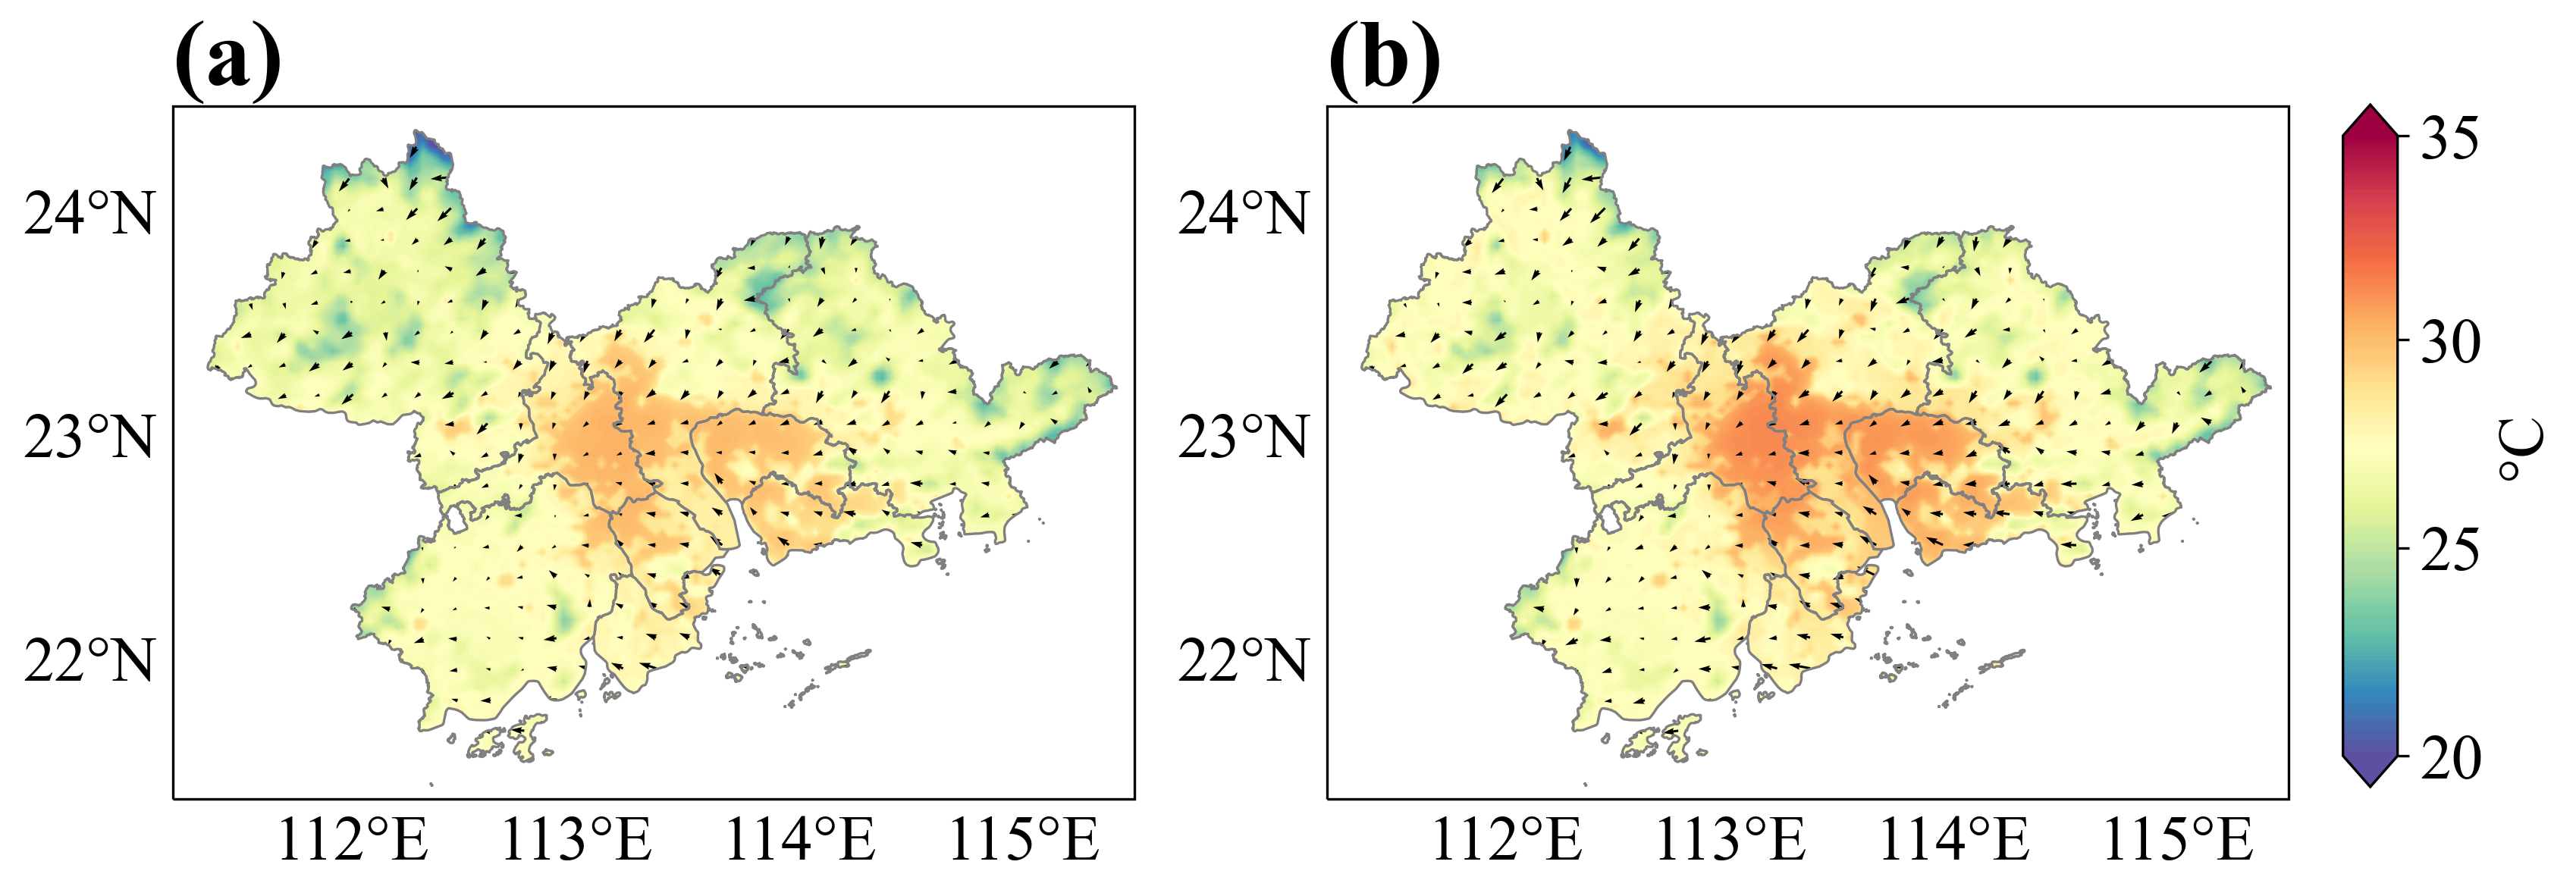

In [5]:
cmin = 20
cmax = 35
cmstep=0.1
cbstep=5

map_noneobs(avg_low, cmin, cmax, cmstep, cbstep,
             mean_low, mean_high,uwind_low, vwind_low,uwind_high, vwind_high,
             ngrid=5, scale=100, headwidth=3,
             colorbar_label='°C')

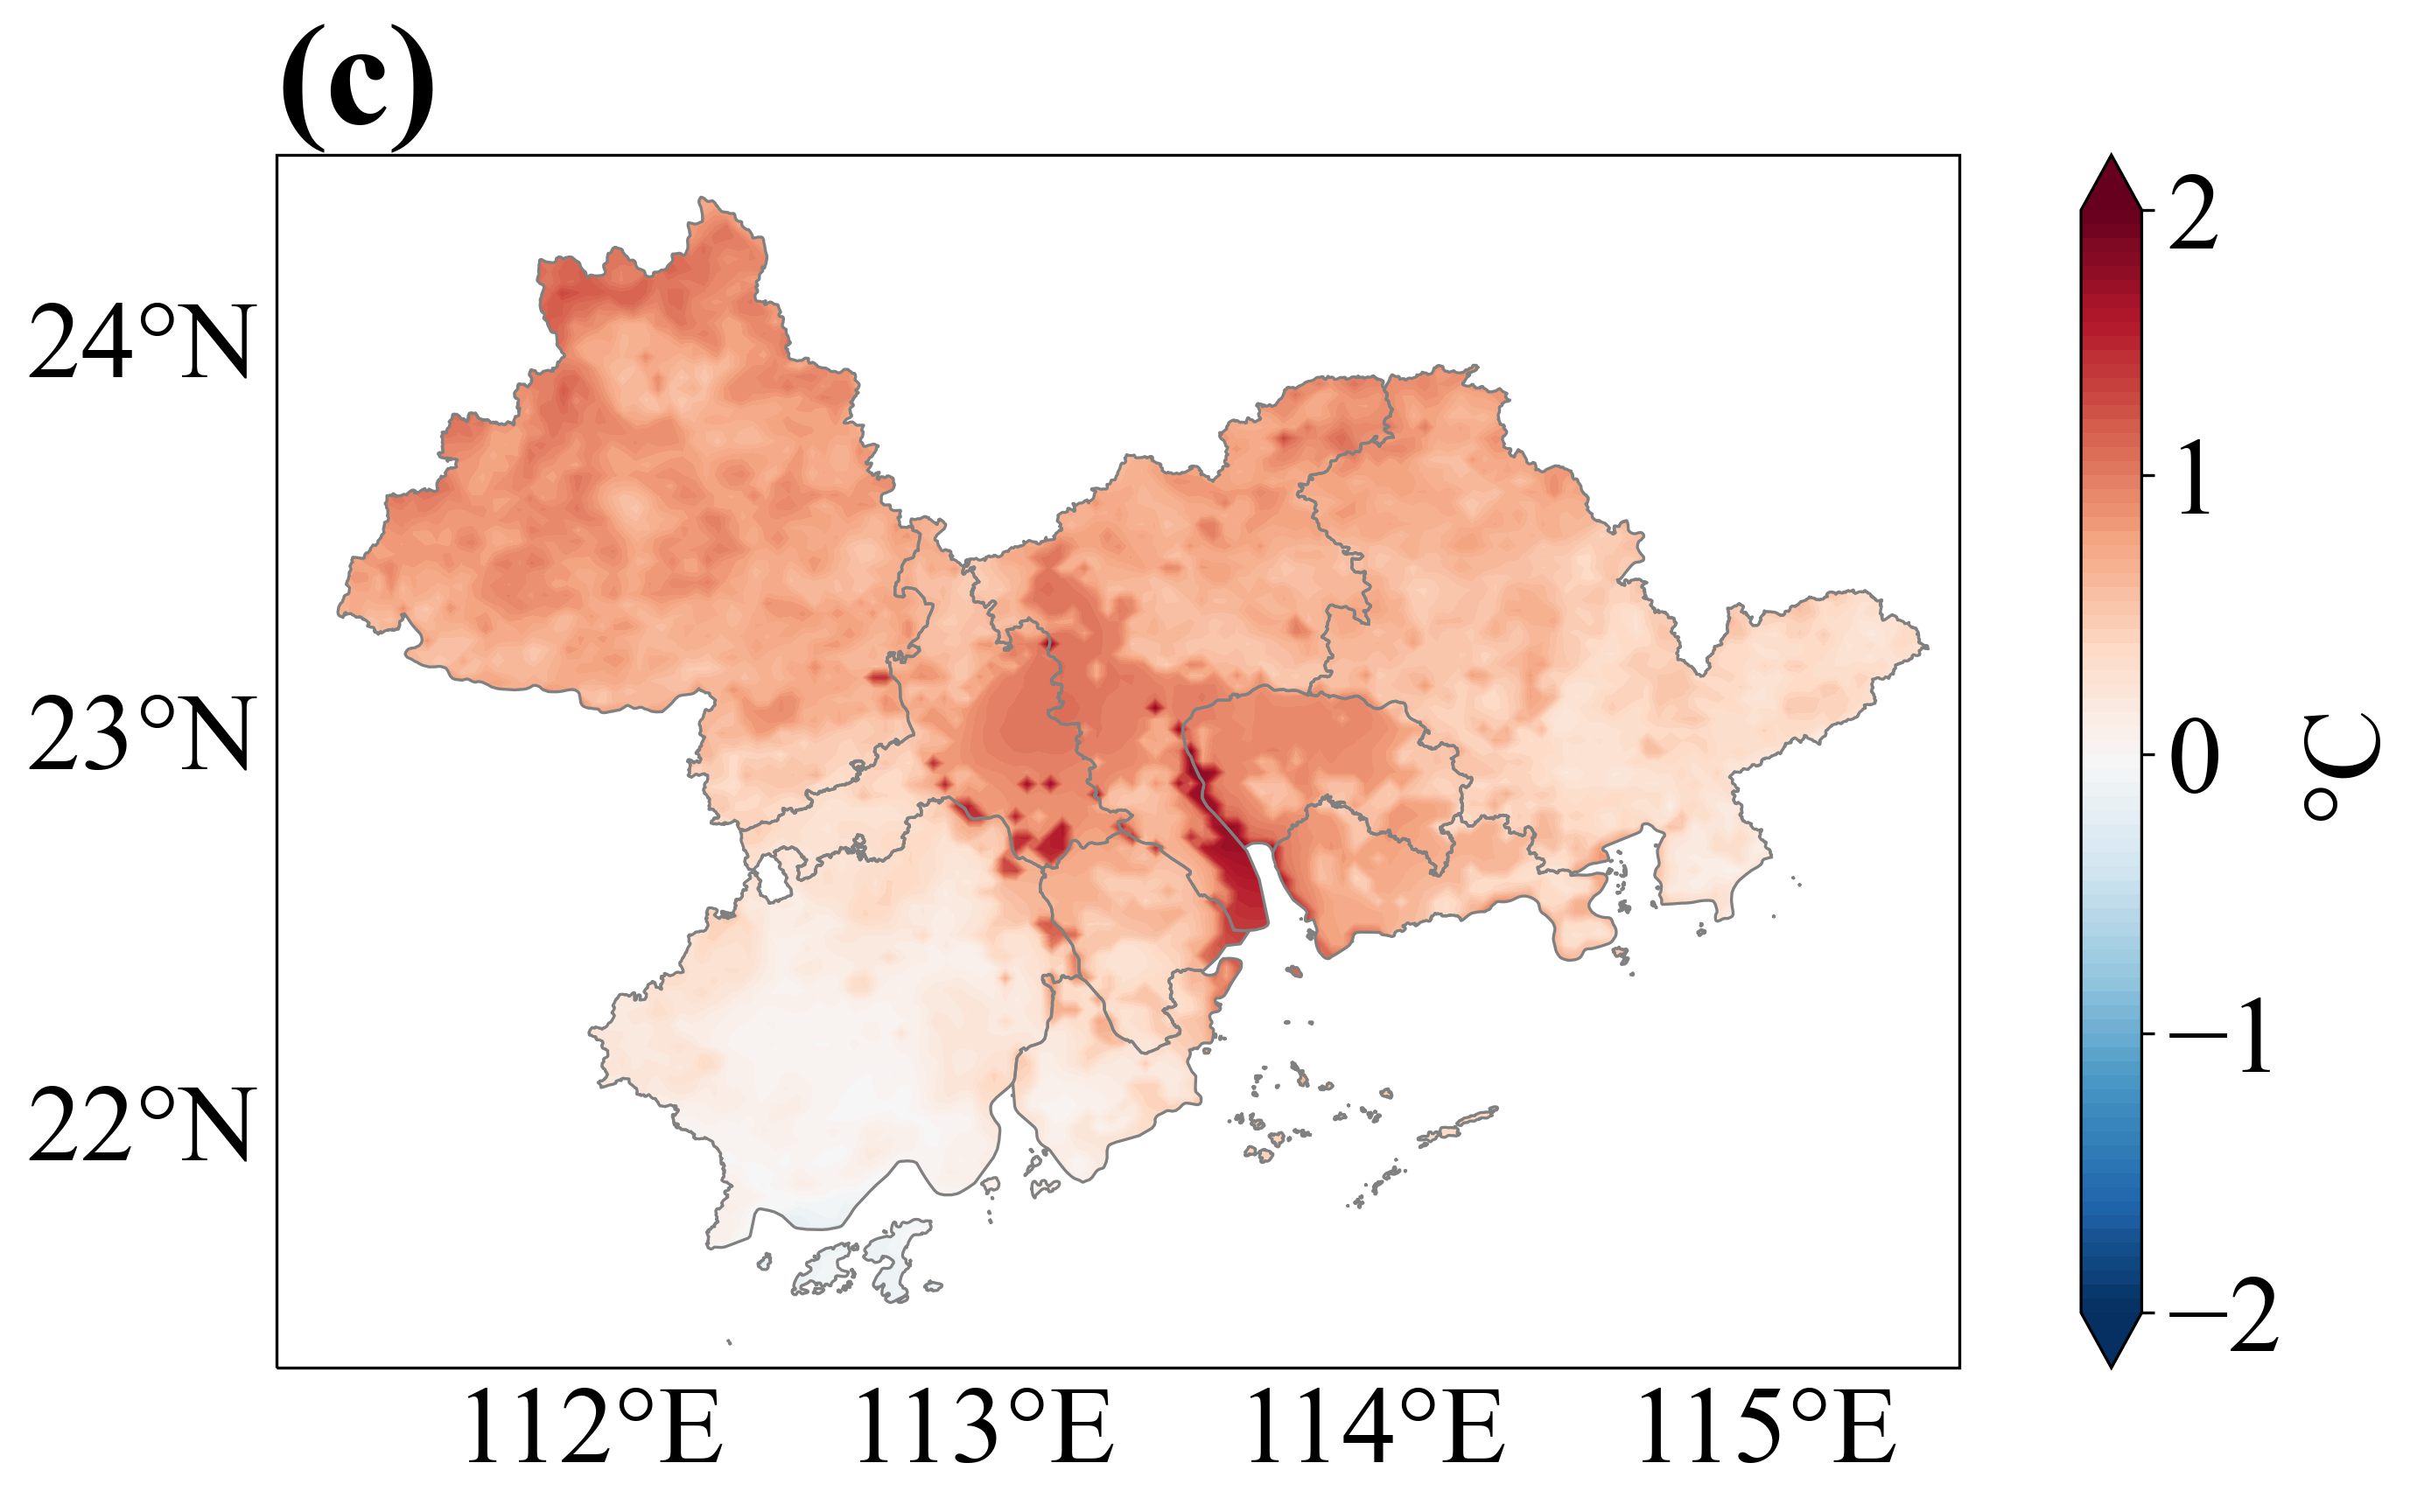

In [6]:
cmin = -2
cmax = 2
cmstep = 0.05
cbstep = 1

diff_noneobs(avg_low, cmin, cmax, cmstep, cbstep,
              mean_low, mean_high,
              title='(c)', colorbar_label='°C')

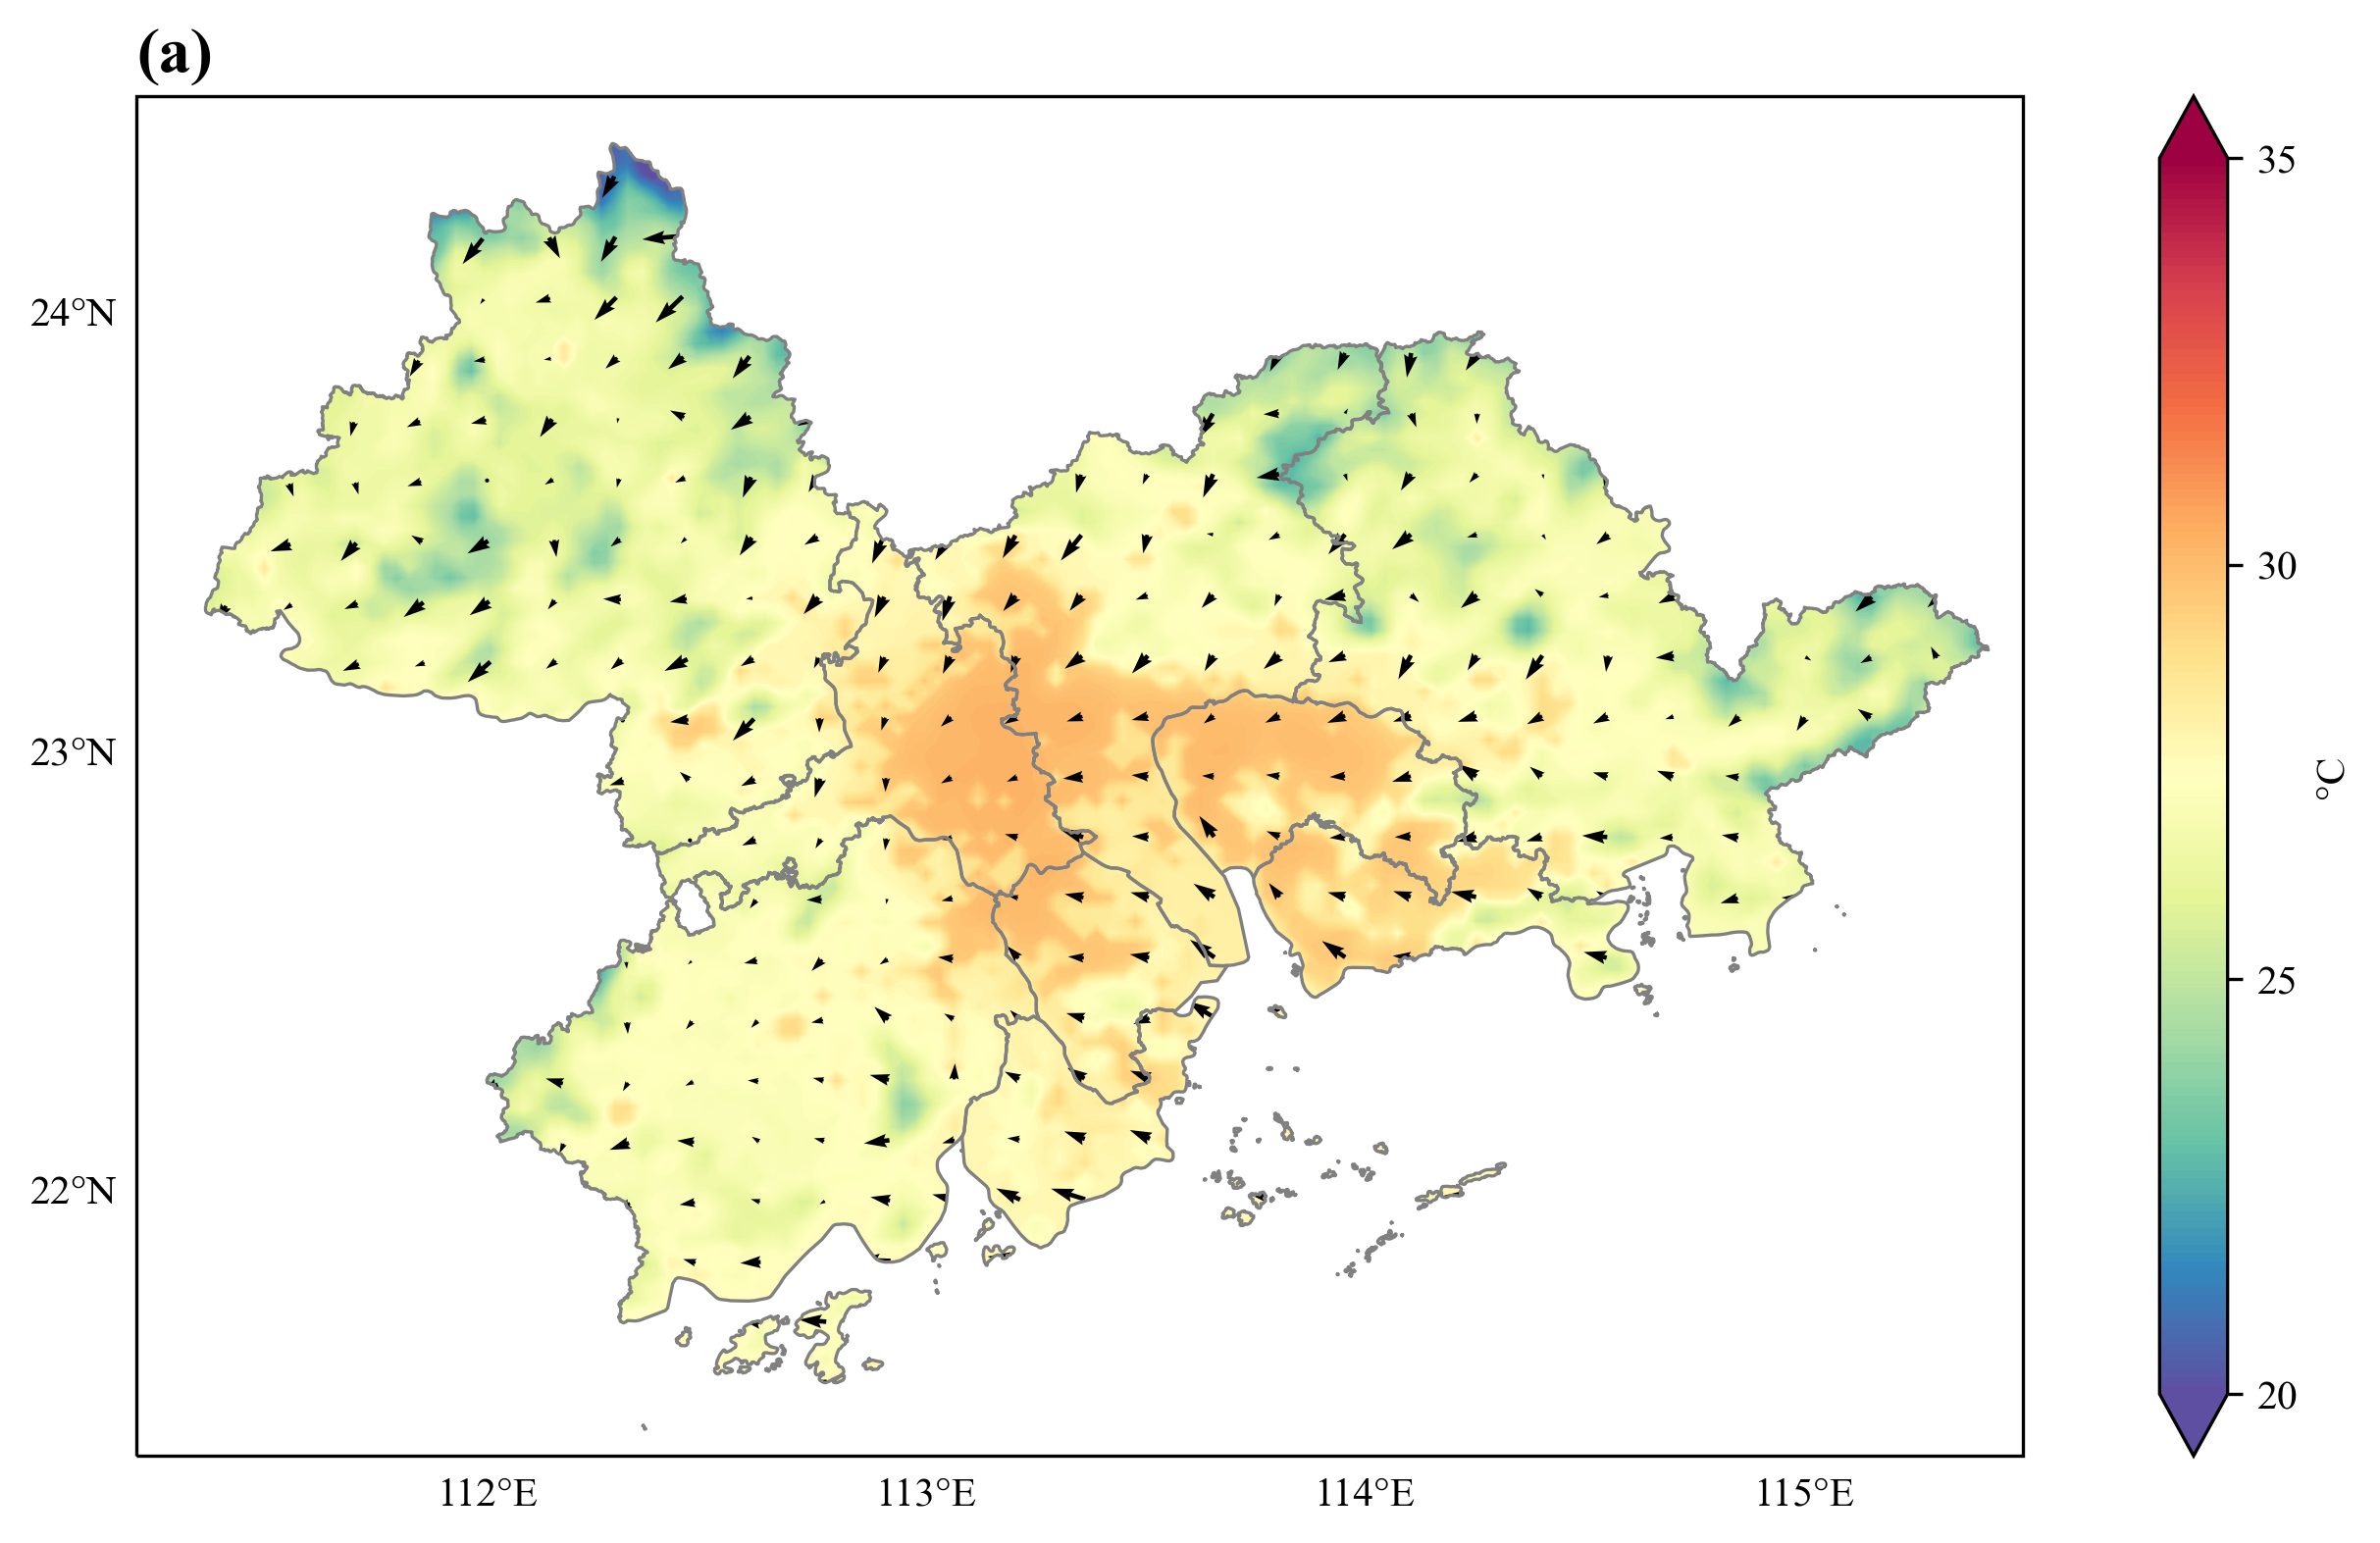

In [31]:
cmin = 20
cmax = 35

lon = avg_low.longitude
lat = avg_low.latitude

proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(12,6),dpi=300)
ax = fig.subplots(1,1,subplot_kw={'projection':proj})

# =============================================
# Defining map boundaries
# =============================================

draw_map(guangzhou, color='gray', linewidth=0.8)
draw_map(foshan, color='gray', linewidth=0.8)
draw_map(shenzhen, color='gray', linewidth=0.8)
draw_map(dongguan, color='gray', linewidth=0.8)
draw_map(zhuhai, color='gray', linewidth=0.8)
draw_map(zhongshan, color='gray', linewidth=0.8)
draw_map(huizhou, color='gray', linewidth=0.8)
draw_map(jiangmen, color='gray', linewidth=0.8)
draw_map(zhaoqing, color='gray', linewidth=0.8)

gl=ax.gridlines(
xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
draw_labels=True, x_inline=False, y_inline=False,
linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False

ax.set_extent([111.2, 115.5, 21.4, 24.5],ccrs.PlateCarree())

# =============================================
# Pollutants concentration & Mask map
# =============================================

cs = ax.contourf(lon, lat, mean_low,
                cmap='Spectral_r',
                levels=np.arange(cmin,cmax,0.1),extend='both',
                transform=ccrs.PlateCarree())

clip_contours_by_map(cs, map_polygon)

# =============================================
# Wind vector map & Mask map
# =============================================

xgrid=np.size(uwind_low,1)
ygrid=np.size(uwind_low,0)
ngrid=5 # 8 for d03

qv = ax.quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uwind_low[0:ygrid:ngrid,0:xgrid:ngrid],vwind_low[0:ygrid:ngrid,0:xgrid:ngrid],
        transform=ccrs.PlateCarree(),color='k',alpha=1,scale=100,headwidth=3)

clip_quiver_by_map(qv, map_polygon)

# =============================================
# Defining title of the map and colorbar
# =============================================

ax.set_title('(a)',loc='left',fontdict={'fontsize': 16, 'fontweight': 'bold'})

cbar=plt.colorbar(cs)
cbar.set_label('°C')
cbar.set_ticks(np.arange(cmin,cmax+1,5))

plt.show()


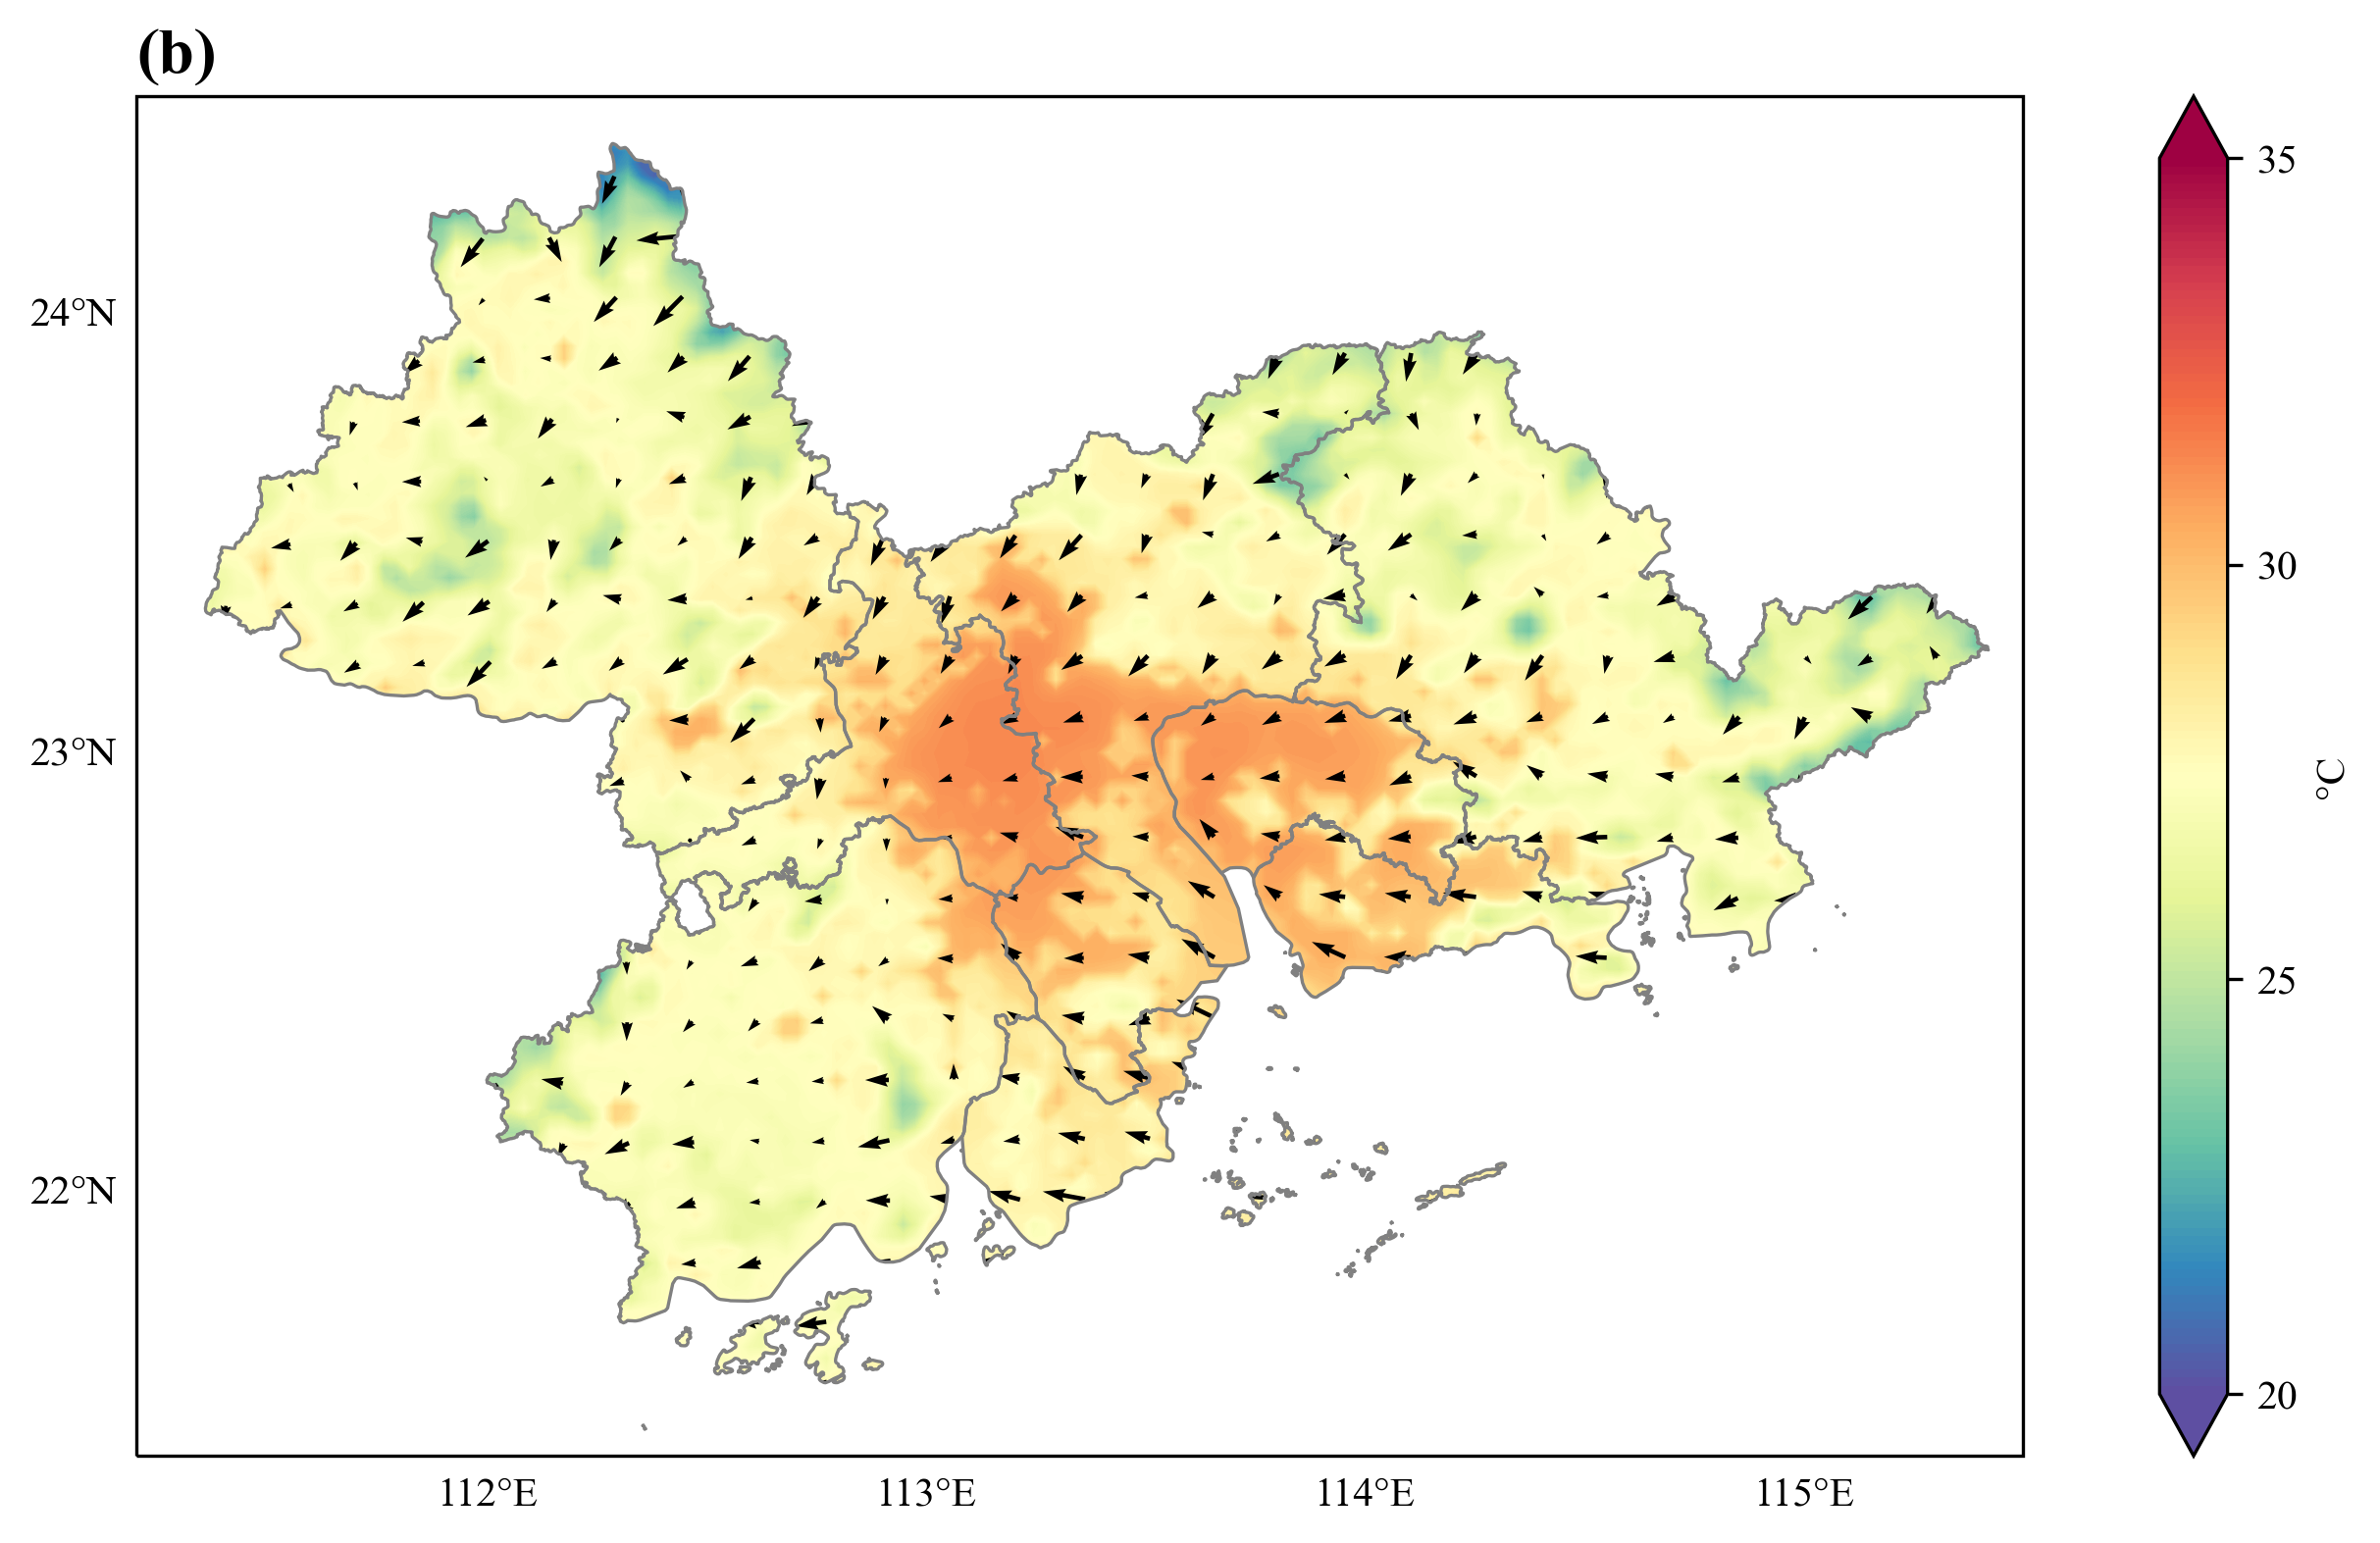

In [32]:
cmin = 20
cmax = 35

lon = avg_low.longitude
lat = avg_low.latitude

proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(12,6),dpi=300)
ax = fig.subplots(1,1,subplot_kw={'projection':proj})

# =============================================
# Defining map boundaries
# =============================================

draw_map(guangzhou, color='gray', linewidth=0.8)
draw_map(foshan, color='gray', linewidth=0.8)
draw_map(shenzhen, color='gray', linewidth=0.8)
draw_map(dongguan, color='gray', linewidth=0.8)
draw_map(zhuhai, color='gray', linewidth=0.8)
draw_map(zhongshan, color='gray', linewidth=0.8)
draw_map(huizhou, color='gray', linewidth=0.8)
draw_map(jiangmen, color='gray', linewidth=0.8)
draw_map(zhaoqing, color='gray', linewidth=0.8)

gl=ax.gridlines(
xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
draw_labels=True, x_inline=False, y_inline=False,
linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False

ax.set_extent([111.2, 115.5, 21.4, 24.5],ccrs.PlateCarree())

# =============================================
# Pollutants concentration & Mask map
# =============================================

cs = ax.contourf(lon, lat, mean_high,
                cmap='Spectral_r',
                levels=np.arange(cmin,cmax,0.1),extend='both',
                transform=ccrs.PlateCarree())

clip_contours_by_map(cs, map_polygon)

# =============================================
# Wind vector map & Mask map
# =============================================

xgrid=np.size(uwind_high,1)
ygrid=np.size(uwind_high,0)
ngrid=5 # 8 for d03

qv = ax.quiver(lon[0:ygrid:ngrid,0:xgrid:ngrid],lat[0:ygrid:ngrid,0:xgrid:ngrid],
        uwind_high[0:ygrid:ngrid,0:xgrid:ngrid],vwind_high[0:ygrid:ngrid,0:xgrid:ngrid],
        transform=ccrs.PlateCarree(),color='k',alpha=1,scale=100,headwidth=3)

clip_quiver_by_map(qv, map_polygon)

# =============================================
# Defining title of the map and colorbar
# =============================================

ax.set_title('(b)',loc='left',fontdict={'fontsize': 16, 'fontweight': 'bold'})

cbar=plt.colorbar(cs)
cbar.set_label('°C')
cbar.set_ticks(np.arange(cmin,cmax+1,5))

plt.show()


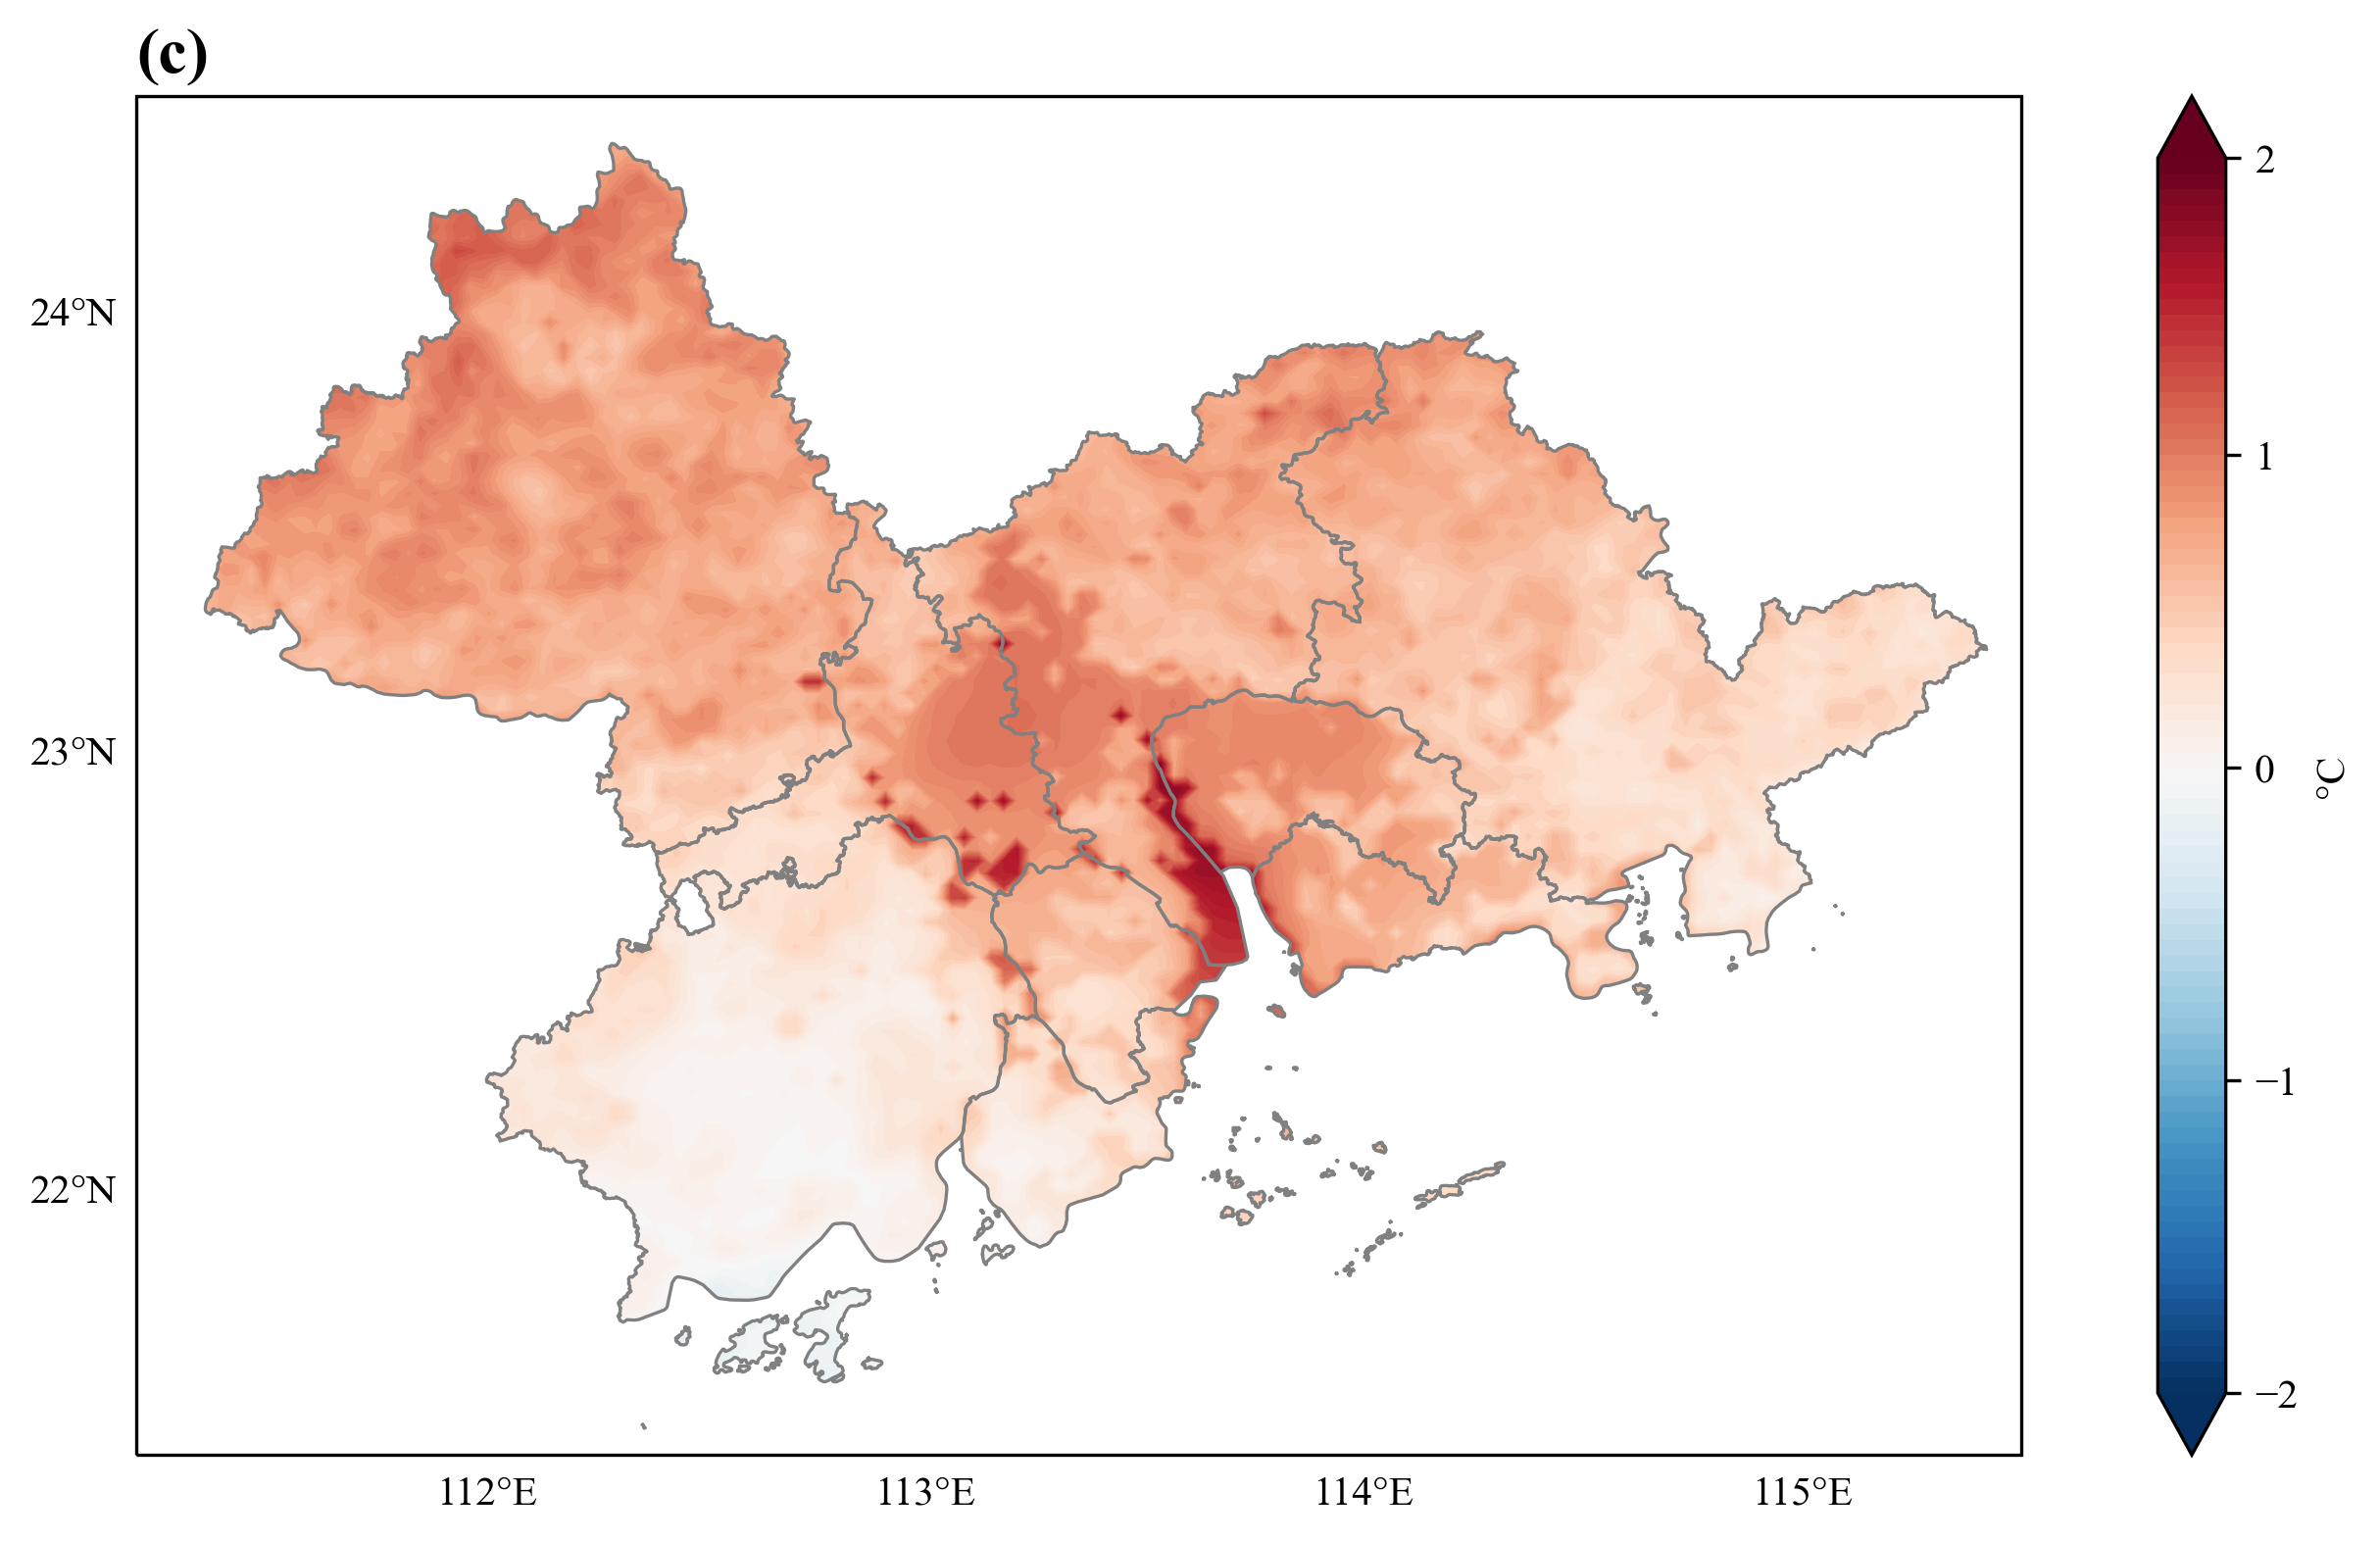

In [33]:
cmin = -2
cmax = 2

lon = avg_low.longitude
lat = avg_low.latitude

proj=ccrs.PlateCarree()

fig = plt.figure(figsize=(12,6),dpi=300)
ax = fig.subplots(1,1,subplot_kw={'projection':proj})

# =============================================
# Defining map boundaries
# =============================================

draw_map(guangzhou, color='gray', linewidth=0.8)
draw_map(foshan, color='gray', linewidth=0.8)
draw_map(shenzhen, color='gray', linewidth=0.8)
draw_map(dongguan, color='gray', linewidth=0.8)
draw_map(zhuhai, color='gray', linewidth=0.8)
draw_map(zhongshan, color='gray', linewidth=0.8)
draw_map(huizhou, color='gray', linewidth=0.8)
draw_map(jiangmen, color='gray', linewidth=0.8)
draw_map(zhaoqing, color='gray', linewidth=0.8)

gl=ax.gridlines(
xlocs=np.arange(-180, 180 + 1, 1), ylocs=np.arange(-90, 90 + 1, 1),
draw_labels=True, x_inline=False, y_inline=False,
linewidth=0, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels =False
gl.rotate_labels=False

ax.set_extent([111.2, 115.5, 21.4, 24.5],ccrs.PlateCarree())

# =============================================
# Pollutants concentration & Mask map
# =============================================

cs = ax.contourf(lon, lat, mean_high-mean_low,
                cmap='RdBu_r',
                levels=np.arange(cmin,cmax,0.05),extend='both',
                transform=ccrs.PlateCarree())

clip_contours_by_map(cs, map_polygon)

# =============================================
# Defining title of the map and colorbar
# =============================================

ax.set_title('(c)',loc='left',fontdict={'fontsize': 16, 'fontweight': 'bold'})

cbar=plt.colorbar(cs)
cbar.set_label('°C')
cbar.set_ticks(np.arange(cmin,cmax+1,1))

plt.show()
 